In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

 
df = pd.read_csv('../data/events.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')



In [4]:
print("Event distribution:")
print(df['event'].value_counts())
print(f"\nTotal unique visitors: {df['visitorid'].nunique():,}")

Event distribution:
event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

Total unique visitors: 1,407,580


In [14]:
all_users = df['visitorid'].unique()
total_users = len(all_users)

viewers = df[df['event'] == 'view']['visitorid'].unique()
num_viewers = len(viewers)

cart_users = df[df['event'] == 'addtocart']['visitorid'].unique()
num_cart = len(cart_users)

purchasers = df[df['event'] == 'transaction']['visitorid'].unique()
num_purchasers = len(purchasers)

#funnel table
funnel_data = {
    'Stage': ['View', 'Add to Cart', 'Purchase'],
    'Users': [num_viewers, num_cart, num_purchasers],
    'Drop-off': [0, num_viewers - num_cart, num_cart - num_purchasers],
    '% of Previous': [100.0,
                    (num_cart/num_viewers*100) if num_viewers > 0 else 0,
                    (num_purchasers/num_cart*100) if num_cart > 0 else 0],
    '% of Total': [(num_viewers/num_viewers*100),
                    (num_cart/num_viewers*100),
                    (num_purchasers/num_viewers*100)]
  }

funnel_df = pd.DataFrame(funnel_data)
print(funnel_df.to_string(index=False))

print(f"\nTotal users in dataset: {total_users:,}")
print(f"Users who only viewed: {num_viewers - num_cart:,}")
print(f"Users who abandoned cart: {num_cart - num_purchasers:,}")
print(f"Users who completed purchase: {num_purchasers:,}")

      Stage   Users  Drop-off  % of Previous  % of Total
       View 1404179         0     100.000000   100.00000
Add to Cart   37722   1366457       2.686410     2.68641
   Purchase   11719     26003      31.066751     0.83458

Total users in dataset: 1,407,580
Users who only viewed: 1,366,457
Users who abandoned cart: 26,003
Users who completed purchase: 11,719


In [13]:
view_to_cart = (num_cart / num_viewers * 100) if num_viewers > 0 else 0
cart_to_purchase = (num_purchasers / num_cart * 100) if num_cart > 0 else 0
view_to_purchase = (num_purchasers / num_viewers * 100) if num_viewers > 0 else 0

conversion_metrics = {
    'Metric': [
        'View → Add to Cart',
        'Add to Cart → Purchase',
        'View → Purchase (Overall)'
      ],
    'Conversion Rate': [
        f'{view_to_cart:.2f}%',
        f'{cart_to_purchase:.2f}%',
        f'{view_to_purchase:.2f}%'
      ],
    'Benchmark (Industry Avg)': [
        '5-10%',
        '25-35%',
        '2-3%'
      ],
    'Status': [
        'Below' if view_to_cart < 5 else 'Good',
        'Good' if cart_to_purchase >= 25 else 'Fair',
        'Fair' if view_to_purchase >= 2 else 'Below'
      ]
  }

conversion_df = pd.DataFrame(conversion_metrics)
print(conversion_df.to_string(index=False))

print("\nKEY INSIGHTS:")
print(f"• Biggest drop-off: {funnel_df.loc[funnel_df['Drop-off'].idxmax(), 'Stage']}")
print(f"• Drop-off size: {funnel_df['Drop-off'].max():,} users")
print(f"• This represents {(funnel_df['Drop-off'].max()/num_viewers*100):.1f}% of all viewers")

                   Metric Conversion Rate Benchmark (Industry Avg) Status
       View → Add to Cart           2.69%                    5-10%  Below
   Add to Cart → Purchase          31.07%                   25-35%   Good
View → Purchase (Overall)           0.83%                     2-3%  Below

KEY INSIGHTS:
• Biggest drop-off: Add to Cart
• Drop-off size: 1,366,457 users
• This represents 97.3% of all viewers


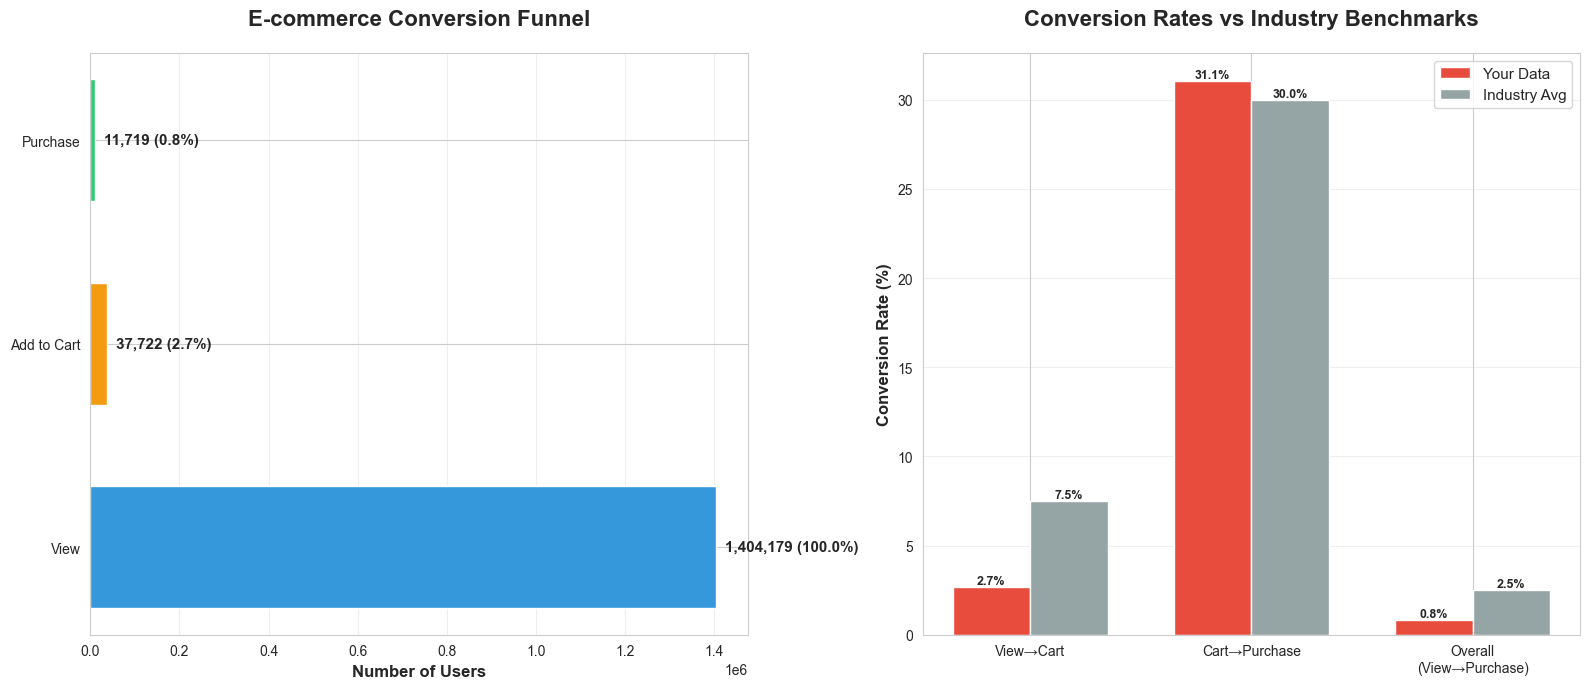

In [15]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))


stages = ['View', 'Add to Cart', 'Purchase']
users = [num_viewers, num_cart, num_purchasers]
colors = ['#3498db', '#f39c12', '#2ecc71']

bars = ax1.barh(stages, users, color=colors, height=0.6)
ax1.set_xlabel('Number of Users', fontsize=12, fontweight='bold')
ax1.set_title('E-commerce Conversion Funnel', fontsize=16, fontweight='bold', pad=20)
ax1.grid(axis='x', alpha=0.3)


for i, (bar, val) in enumerate(zip(bars, users)):
    width = bar.get_width()
    pct = (val / num_viewers * 100)
    ax1.text(width + 20000, bar.get_y() + bar.get_height()/2, 
             f'{val:,} ({pct:.1f}%)', 
             va='center', fontweight='bold', fontsize=11)

conversion_names = ['View→Cart', 'Cart→Purchase', 'Overall\n(View→Purchase)']
conversion_values = [view_to_cart, cart_to_purchase, view_to_purchase]
benchmarks = [7.5, 30, 2.5]  # Midpoint of industry benchmarks

x = np.arange(len(conversion_names))
width = 0.35

bars1 = ax2.bar(x - width/2, conversion_values, width, label='Your Data', color='#e74c3c')
bars2 = ax2.bar(x + width/2, benchmarks, width, label='Industry Avg', color='#95a5a6')

ax2.set_ylabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Conversion Rates vs Industry Benchmarks', fontsize=16, fontweight='bold', pad=20)
ax2.set_xticks(x)
ax2.set_xticklabels(conversion_names, fontsize=10)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

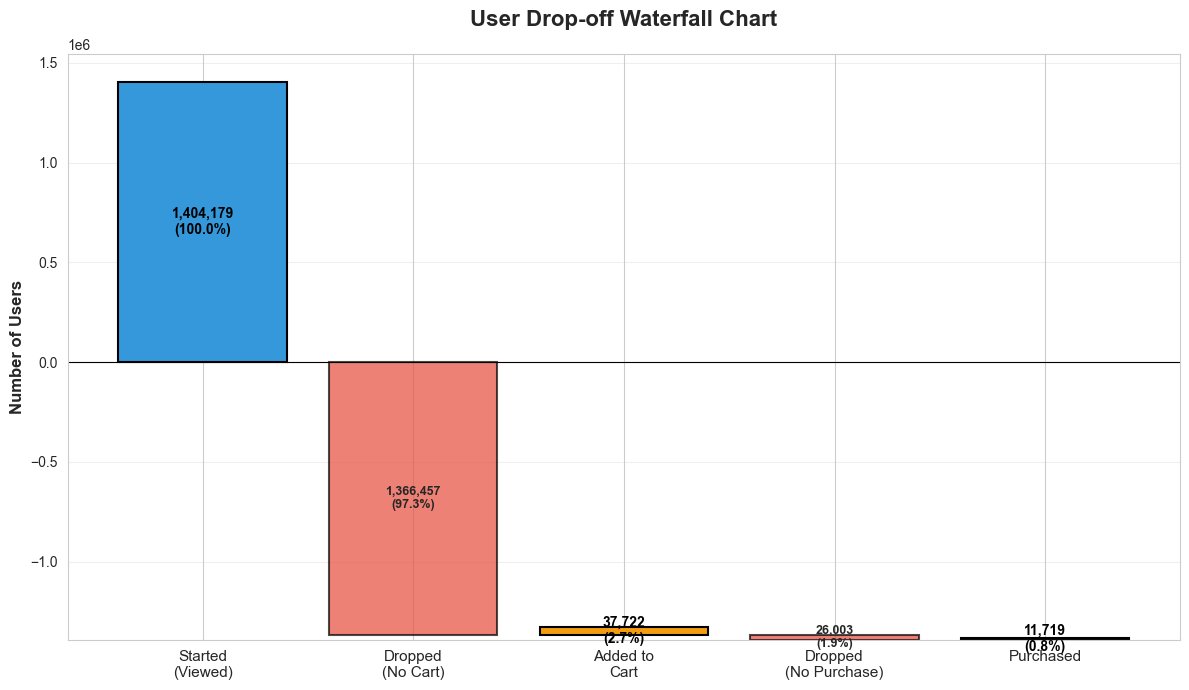

KEY TAKEAWAY:
Of 1,404,179 viewers, you lose 1,366,457 (97.3%) before cart.
This is the primary optimization opportunity.


In [18]:
fig, ax = plt.subplots(figsize=(12, 7))

started = num_viewers
after_view = num_cart
after_cart = num_purchasers

drop_after_view = started - after_view
drop_after_cart = after_view - after_cart

categories = ['Started\n(Viewed)', 'Dropped\n(No Cart)', 'Added to\nCart', 'Dropped\n(No Purchase)', 'Purchased']
values = [started, -drop_after_view, after_view, -drop_after_cart, after_cart]
colors_list = ['#3498db', '#e74c3c', '#f39c12', '#e74c3c', '#2ecc71']

bottom = 0
for i, (cat, val, col) in enumerate(zip(categories, values, colors_list)):
    if val >= 0:
        ax.bar(i, val, bottom=bottom, color=col, edgecolor='black', linewidth=1.5)
        ax.text(i, bottom + val/2, f'{val:,}\n({val/started*100:.1f}%)', 
                ha='center', va='center', fontweight='bold', fontsize=10, color='black')
    else:
        ax.bar(i, -val, bottom=bottom + val, color=col, edgecolor='black', linewidth=1.5, alpha=0.7)
        ax.text(i, bottom + val/2, f'{-val:,}\n({-val/started*100:.1f}%)', 
                ha='center', va='center', fontweight='bold', fontsize=9)
    
    if val < 0:
        bottom += val

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylabel('Number of Users', fontsize=12, fontweight='bold')
ax.set_title('User Drop-off Waterfall Chart', fontsize=16, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("KEY TAKEAWAY:")
print(f"Of {started:,} viewers, you lose {drop_after_view:,} ({drop_after_view/started*100:.1f}%) before cart.")
print(f"This is the primary optimization opportunity.")

In [23]:

user_events = df.sort_values(['visitorid', 'timestamp']).copy()

user_first_events = user_events.groupby(['visitorid', 'event'])['timestamp'].min().unstack()

time_to_cart = (user_first_events['addtocart'] - user_first_events['view']).dt.total_seconds() / 60
time_to_cart = time_to_cart.dropna()

time_to_purchase = (user_first_events['transaction'] - user_first_events['addtocart']).dt.total_seconds() / 60
time_to_purchase = time_to_purchase.dropna()

total_time_to_purchase = (user_first_events['transaction'] - user_first_events['view']).dt.total_seconds() / 60
total_time_to_purchase = total_time_to_purchase.dropna()

time_summary = {
    'Stage Transition': [
        'View → Add to Cart',
        'Add to Cart → Purchase',
        'View → Purchase (Total)'
    ],
    'Median Time': [
        f'{time_to_cart.median():.1f} min',
        f'{time_to_purchase.median():.1f} min',
        f'{total_time_to_purchase.median():.1f} min'
    ],
    'Average Time': [
        f'{time_to_cart.mean():.1f} min',
        f'{time_to_purchase.mean():.1f} min',
        f'{total_time_to_purchase.mean():.1f} min'
    ]
}

time_df = pd.DataFrame(time_summary)
print(time_df.to_string(index=False))

print(f"\n{'='*70}")
print("INSIGHTS:")
print(f"• 50% of cart adds happen within {time_to_cart.median():.0f} minutes of first view")
print(f"• 50% of purchases happen within {time_to_purchase.median():.0f} minutes of adding to cart")
print(f"• Total median journey: {total_time_to_purchase.median():.0f} minutes from view to purchase")

       Stage Transition Median Time Average Time
     View → Add to Cart     3.1 min   4099.1 min
 Add to Cart → Purchase     5.7 min    730.9 min
View → Purchase (Total)    20.2 min   5522.7 min

INSIGHTS:
• 50% of cart adds happen within 3 minutes of first view
• 50% of purchases happen within 6 minutes of adding to cart
• Total median journey: 20 minutes from view to purchase


In [24]:
item_views = df[df['event'] == 'view'].groupby('itemid').size()
item_carts = df[df['event'] == 'addtocart'].groupby('itemid').size()
item_purchases = df[df['event'] == 'transaction'].groupby('itemid').size()

item_funnel = pd.DataFrame({
    'views': item_views,
    'carts': item_carts,
    'purchases': item_purchases
}).fillna(0)

# Calculate conversion rates
item_funnel['view_to_purchase_%'] = (item_funnel['purchases'] / item_funnel['views'] * 100)

# Filter items with at least 100 views for statistical significance
significant_items = item_funnel[item_funnel['views'] >= 100].copy()

print(f"Total items: {len(item_funnel):,}")
print(f"Items with 100+ views: {len(significant_items):,}\n")

print("TOP 10 CONVERTING ITEMS (View → Purchase):")
top_items = significant_items.nlargest(10, 'view_to_purchase_%')[['views', 'purchases', 'view_to_purchase_%']]
print(top_items.to_string())

print("\n" + "="*70)
print("\nWORST 10 CONVERTING ITEMS (View → Purchase):")
worst_items = significant_items.nsmallest(10, 'view_to_purchase_%')[['views', 'purchases', 'view_to_purchase_%']]
print(worst_items.to_string())

print("\n" + "="*70)
print(f"\nBest item conversion: {significant_items['view_to_purchase_%'].max():.2f}%")
print(f"Worst item conversion: {significant_items['view_to_purchase_%'].min():.2f}%")
print(f"Average item conversion: {significant_items['view_to_purchase_%'].mean():.2f}%")

Total items: 235,061
Items with 100+ views: 3,984

TOP 10 CONVERTING ITEMS (View → Purchase):
        views  purchases  view_to_purchase_%
itemid                                      
213834  293.0       92.0           31.399317
334401  200.0       28.0           14.000000
119736  752.0       97.0           12.898936
140527  111.0       12.0           10.810811
256146  130.0       14.0           10.769231
220513  101.0       10.0            9.900990
246532  113.0       11.0            9.734513
288525  178.0       16.0            8.988764
174489  146.0       13.0            8.904110
92466   181.0       16.0            8.839779


WORST 10 CONVERTING ITEMS (View → Purchase):
        views  purchases  view_to_purchase_%
itemid                                      
1489    186.0        0.0                 0.0
1981    136.0        0.0                 0.0
2206    113.0        0.0                 0.0
2331    149.0        0.0                 0.0
2716    103.0        0.0                 0.0
2992

          Stage  Users Started  Users Completed  Users Dropped Drop-off Rate Retention Rate
    View → Cart        1404179            37722        1366457        97.31%          2.69%
Cart → Purchase          37722            11719          26003        68.93%         31.07%

CRITICAL LEAK POINT:

PRIMARY LEAK: View → Add to Cart
   • Lost users: 1,366,457
   • Drop-off rate: 97.3%

REVENUE OPPORTUNITY:
   • Current View→Cart rate: 2.69%
   • Industry benchmark: 5-10%
   • If you improve to 5%:
     → Additional cart adds: 32,486
     → Additional purchases: 10,092
     → Revenue increase: 86.1%


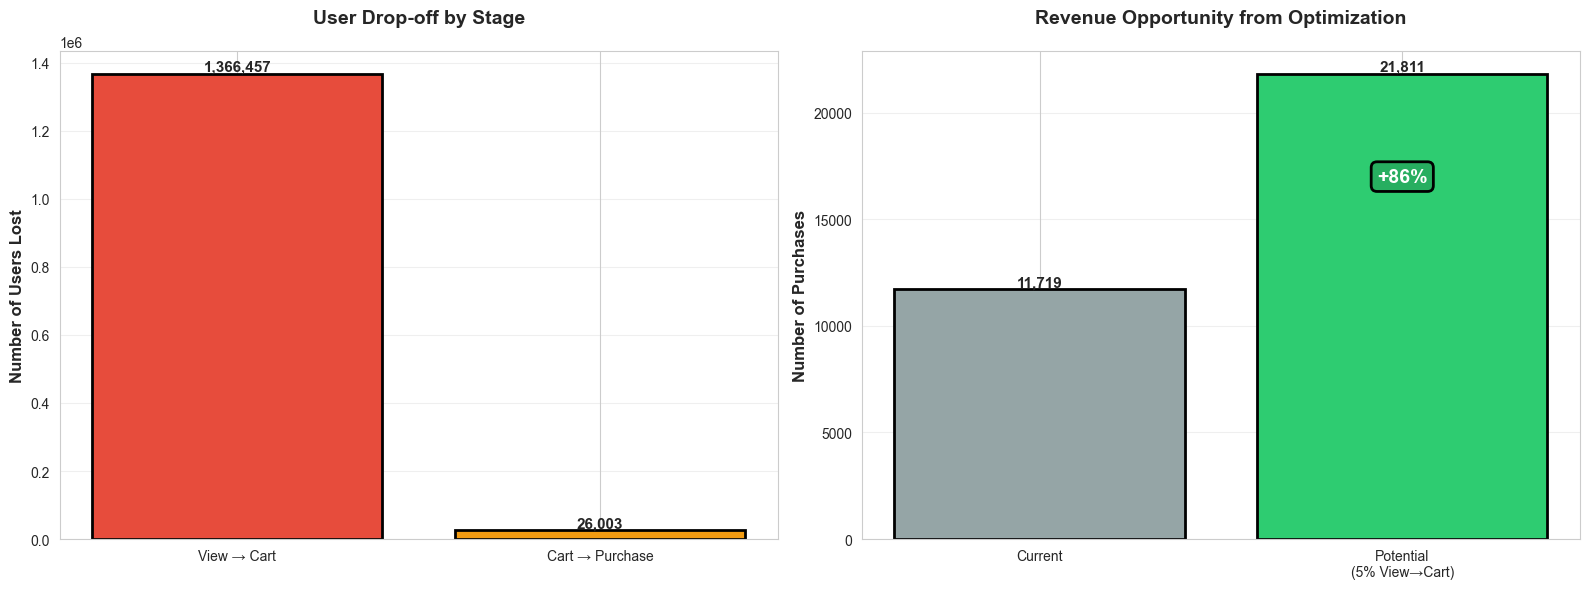

In [25]:
# Calculate drop-offs
view_to_cart_drop = num_viewers - num_cart
cart_to_purchase_drop = num_cart - num_purchasers

# Create drop-off summary
drop_off_summary = {
    'Stage': ['View → Cart', 'Cart → Purchase'],
    'Users Started': [num_viewers, num_cart],
    'Users Completed': [num_cart, num_purchasers],
    'Users Dropped': [view_to_cart_drop, cart_to_purchase_drop],
    'Drop-off Rate': [
        f'{(view_to_cart_drop / num_viewers * 100):.2f}%',
        f'{(cart_to_purchase_drop / num_cart * 100):.2f}%'
    ],
    'Retention Rate': [
        f'{(num_cart / num_viewers * 100):.2f}%',
        f'{(num_purchasers / num_cart * 100):.2f}%'
    ]
}

drop_off_df = pd.DataFrame(drop_off_summary)
print(drop_off_df.to_string(index=False))

print("\n" + "="*70)
print("CRITICAL LEAK POINT:\n")

print(f"PRIMARY LEAK: View → Add to Cart")
print(f"   • Lost users: {view_to_cart_drop:,}")
print(f"   • Drop-off rate: {(view_to_cart_drop / num_viewers * 100):.1f}%")

print(f"\nREVENUE OPPORTUNITY:")
print(f"   • Current View→Cart rate: {view_to_cart:.2f}%")
print(f"   • Industry benchmark: 5-10%")
print(f"   • If you improve to 5%:")

additional_carts = num_viewers * 0.05 - num_cart
additional_purchases = additional_carts * (num_purchasers / num_cart)

print(f"     → Additional cart adds: {int(additional_carts):,}")
print(f"     → Additional purchases: {int(additional_purchases):,}")
print(f"     → Revenue increase: {(additional_purchases / num_purchasers * 100):.1f}%")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

stages_drop = ['View → Cart', 'Cart → Purchase']
drop_counts = [view_to_cart_drop, cart_to_purchase_drop]
drop_colors = ['#e74c3c', '#f39c12']

bars = ax1.bar(stages_drop, drop_counts, color=drop_colors, edgecolor='black', linewidth=2)
ax1.set_ylabel('Number of Users Lost', fontsize=12, fontweight='bold')
ax1.set_title('User Drop-off by Stage', fontsize=14, fontweight='bold', pad=20)
ax1.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, drop_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

current_purchases = num_purchasers
potential_purchases = num_purchasers + int(additional_purchases)

categories_rev = ['Current', 'Potential\n(5% View→Cart)']
purchase_counts = [current_purchases, potential_purchases]
colors_rev = ['#95a5a6', '#2ecc71']

bars = ax2.bar(categories_rev, purchase_counts, color=colors_rev, edgecolor='black', linewidth=2)
ax2.set_ylabel('Number of Purchases', fontsize=12, fontweight='bold')
ax2.set_title('Revenue Opportunity from Optimization', fontsize=14, fontweight='bold', pad=20)
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, purchase_counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

increase_pct = (additional_purchases / num_purchasers * 100)
ax2.text(1, current_purchases + int(additional_purchases/2), 
         f'+{increase_pct:.0f}%', ha='center', fontsize=14, 
         fontweight='bold', color='white', 
         bbox=dict(boxstyle='round', facecolor='#27ae60', edgecolor='black', linewidth=2))

plt.tight_layout()
plt.show()

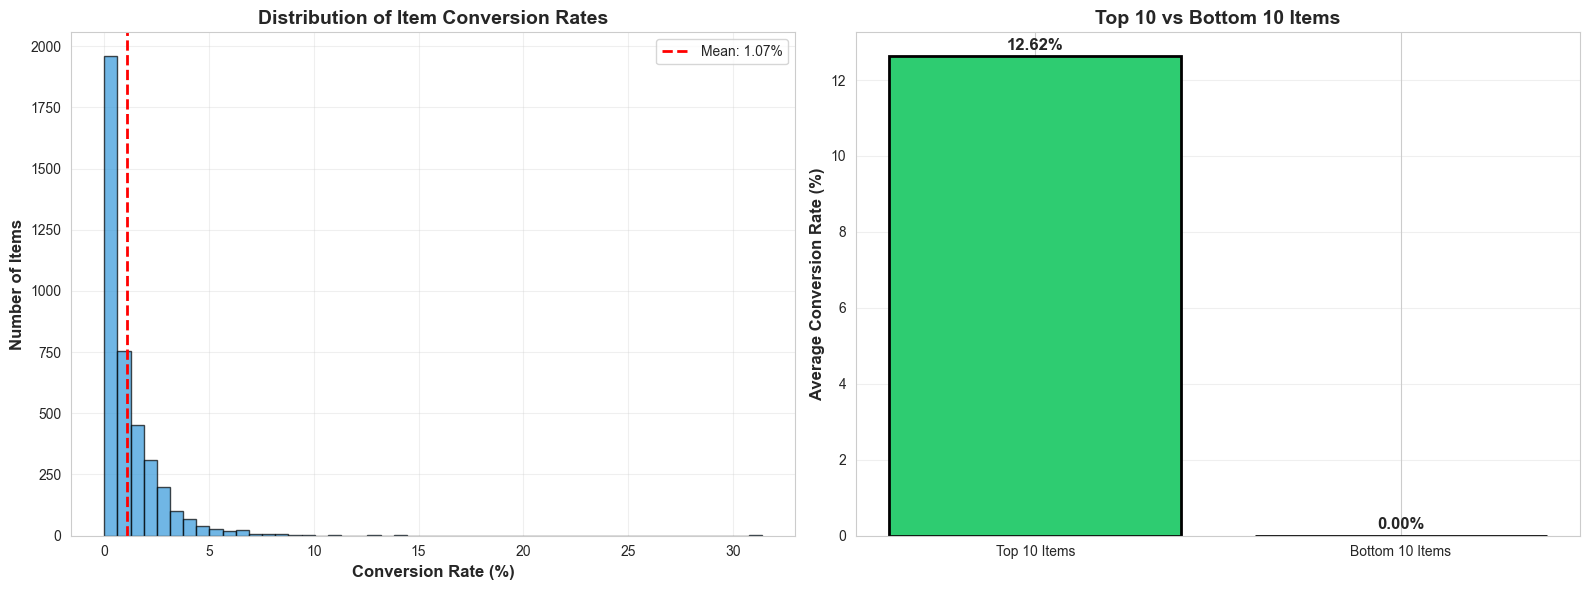

In [26]:
# Visualize item conversion distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Distribution of conversion rates
ax1.hist(significant_items['view_to_purchase_%'], bins=50, color='#3498db', edgecolor='black', alpha=0.7)
ax1.axvline(significant_items['view_to_purchase_%'].mean(), color='red', linestyle='--', 
            linewidth=2, label=f"Mean: {significant_items['view_to_purchase_%'].mean():.2f}%")
ax1.set_xlabel('Conversion Rate (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Items', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Item Conversion Rates', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Right: Top 10 vs Bottom 10
top_10 = significant_items.nlargest(10, 'view_to_purchase_%')
bottom_10 = significant_items.nsmallest(10, 'view_to_purchase_%')

categories = ['Top 10 Items', 'Bottom 10 Items']
avg_conversion = [top_10['view_to_purchase_%'].mean(), bottom_10['view_to_purchase_%'].mean()]
colors_bar = ['#2ecc71', '#e74c3c']

bars = ax2.bar(categories, avg_conversion, color=colors_bar, edgecolor='black', linewidth=2)
ax2.set_ylabel('Average Conversion Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Top 10 vs Bottom 10 Items', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

for bar, val in zip(bars, avg_conversion):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{val:.2f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()